In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
from scipy.optimize import fmin
from datetime import datetime
import yfinance as yf
import os
from scipy.stats import kurtosis
from statsmodels.tsa.arima.model import ARIMA
from tqdm.notebook import tqdm
from statsmodels.stats.stattools import jarque_bera
from arch import arch_model
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.diagnostic import het_arch
from arch import univariate
import sys

### Q1 (Python and GARCH h=10 step ahead forecasting)

In [27]:
# Download data automatically if file not present
name_bhp = 'bhp_yf_2010_2021.csv'

# BHP
if not os.path.isfile(name_bhp):
    data_bhp = yf.download("BHP.AX", start='2010-01-01', end='2021-10-23')
    data_bhp.to_csv(name_bhp)
    
data = pd.read_csv(name_bhp, index_col='Date', parse_dates=True, dayfirst=True)
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,39.947372,40.423939,39.909992,40.255737,22.826643,3949861
2010-01-05,40.648205,40.779026,40.395905,40.442627,22.932615,9721826
2010-01-06,40.722958,40.975258,40.685581,40.947224,23.218742,6951354
2010-01-07,41.031322,41.246246,40.881813,40.900501,23.192249,7091269
2010-01-08,40.825748,40.993946,40.648205,40.760338,23.112768,4906718


In [28]:
# It is actually not necessary to truncate the return
# series; we do it to speed up the forecasting later.
p = data['Adj Close']
r_all = 100 * np.log(p).diff().dropna()
r = r_all[:'2019-11-04']
r.head()

Date
2010-01-05    0.463174
2010-01-06    1.239967
2010-01-07   -0.114167
2010-01-08   -0.343294
2010-01-11    1.929903
Name: Adj Close, dtype: float64

#### (b) After 4/11/2019, generate 10 step-ahead forecasts of volatility for the models: ARCH(5), GARCH, GJR-GARCH, EGARCH, all with Gaussian errors and constant means; plus the RM model. Update the forecast origin for each forecast, until the end of the forecast sample. Re-estimate the parameter estimates every 100 days. Also include the HS25, HS100 and HS-T methods. Plot these forecasts, parametric and HS in separate plots, and comment on their apparent forecast accuracy.  (this took 5 mins on my laptop)


Takes less than 1 minute on mine!

In [29]:
n_fore = len(r_all) - len(r) - 9

farch5_10 = pd.Series(index=r_all[-n_fore:].index, dtype='float64')

arch5_all = arch_model(r_all, mean='Constant', vol='ARCH', p=5, dist='Normal')

n_wind = len(r)
for i in tqdm(range(n_fore)):
    if i % 100 == 0:
        arch5_all_fit = arch5_all.fit(first_obs=i, last_obs=(i + n_wind), disp="off")
        temp = arch5_all_fit.forecast(horizon=10, align='target', reindex=False).variance
    
    farch5_10[i] = temp.loc[farch5_10.index[i]]['h.10']

  0%|          | 0/491 [00:00<?, ?it/s]

In [30]:
n_fore = len(r_all) - len(r) - 9

fgarch11_10 = pd.Series(index=r_all[-n_fore:].index, dtype='float64')

garch11_all = arch_model(r_all, mean='Constant', vol='GARCH', p=1, q=1, dist='Normal')

n_wind = len(r)
for i in tqdm(range(n_fore)):
    if i % 100 == 0:
        garch11_all_fit = garch11_all.fit(first_obs=i, last_obs=i + n_wind, disp="off")
    
        temp = garch11_all_fit.forecast(horizon=10, align='target', reindex=False).variance
        
    fgarch11_10[i] = temp.loc[fgarch11_10.index[i]]['h.10']

  0%|          | 0/491 [00:00<?, ?it/s]

In [31]:
n_fore = len(r_all) - len(r) - 9

fgjr11_10 = pd.Series(index=r_all[-n_fore:].index, dtype='float64')

gjr11_all = arch_model(r_all, mean='Constant', vol='GARCH', p=1, o=1, q=1, dist='Normal')

n_wind = len(r)
for i in tqdm(range(n_fore)):
    if i % 100 == 0:
        gjr11_all_fit = gjr11_all.fit(first_obs=i, last_obs=i + n_wind, disp="off")
    
        temp = gjr11_all_fit.forecast(horizon=10, align='target', reindex=False).variance
    
    fgjr11_10[i] = temp.loc[fgjr11_10.index[i]]['h.10']

  0%|          | 0/491 [00:00<?, ?it/s]

Notice that in the tutorial they are only able to perform 1,000 simulations, but I can perform 10,000 simulations and still be under 1 minute of runtime. As such, should probably increase the number of simulations for more accuracy.

In [32]:
n_fore = len(r_all) - len(r) - 9

fegarch_10 = pd.Series(index=r_all[-n_fore:].index, dtype='float64')

egarch_all = arch_model(r_all, mean='Constant', vol='EGARCH', p=1, o=1, q=1, dist='Normal')

n_wind = len(r)
for i in tqdm(range(n_fore)):
    if i % 100 == 0:
        egarch_all_fit = egarch_all.fit(first_obs=i, last_obs=i + n_wind, disp="off")
    
        temp = egarch_all_fit.forecast(horizon=10, method='simulation', simulations=10000, 
                                       align='target', reindex=False).variance
    
    fegarch_10[i] = temp.loc[fegarch_10.index[i]]['h.10']

  0%|          | 0/491 [00:00<?, ?it/s]

In [33]:
n_fore = len(r_all) - len(r) - 9

frm_10 = pd.Series(index=r_all[-n_fore:].index, dtype='float64')

rm_all = arch_model(r_all, mean='Zero', vol='GARCH', p=1, q=1, dist='Normal')

n_wind = len(r)
for i in tqdm(range(n_fore)):
    if i % 100 == 0:
        rm_all_fit = rm_all.fit(first_obs=i, last_obs=i + n_wind, disp="off")
 
        temp = rm_all_fit.forecast(horizon=10, align='target', reindex=False).variance
    
    frm_10[i] = temp.loc[frm_10.index[i]]['h.10']

  0%|          | 0/491 [00:00<?, ?it/s]

In [35]:
n_fore = len(r_all) - len(r) - 9

fs2_T_10 = pd.Series(index=r_all[-n_fore:].index, dtype='float64')
fs2_100_10 = pd.Series(index=r_all[-n_fore:].index, dtype='float64')
fs2_25_10 = pd.Series(index=r_all[-n_fore:].index, dtype='float64')

n_wind = len(r)
for i in tqdm(range(n_fore)):
    fs2_T_10[i] = r_all[:(i + n_wind)].var()
    fs2_100_10[i] = r_all[(i + n_wind - 100):(i + n_wind)].var()
    fs2_25_10[i] = r_all[(i + n_wind - 25):(i + n_wind)].var()

  0%|          | 0/491 [00:00<?, ?it/s]

In [36]:
# Volatility proxies
rng = 100 * (np.log(data['High']) - np.log(data['Low']))[1:]
rng[rng <= 0] = np.mean([0, np.min(rng[rng > 0])])
ovn = 100 * (np.log(data['Open']) - np.log(data['Close']).shift(1)).dropna()

proxy1 = (r_all - r_all.mean()) ** 2
proxy2 = 0.3607 * rng ** 2
proxy3 = 1.107 * proxy2 + 0.68 * ovn ** 2
proxy4 = np.exp(2 * np.log(rng) - 0.86 + 2 * 0.29 ** 2)

# ten trading days ahead of forst origin, to coincide with the 10 day forecast from origin (4/11/19)
f_proxy1 = proxy1['2019-11-16':]
f_proxy2 = proxy2['2019-11-16':]
f_proxy3 = proxy3['2019-11-16':]
f_proxy4 = proxy4['2019-11-16':]

len(f_proxy1)

491

Notice that the EGARCH forecasts is based on simulations, and so should be random each time you forecast. But my image is the exact same as the one in the Canvas notebooks. Moreover, since we did 10x more simulations our forcast should be more accurate!

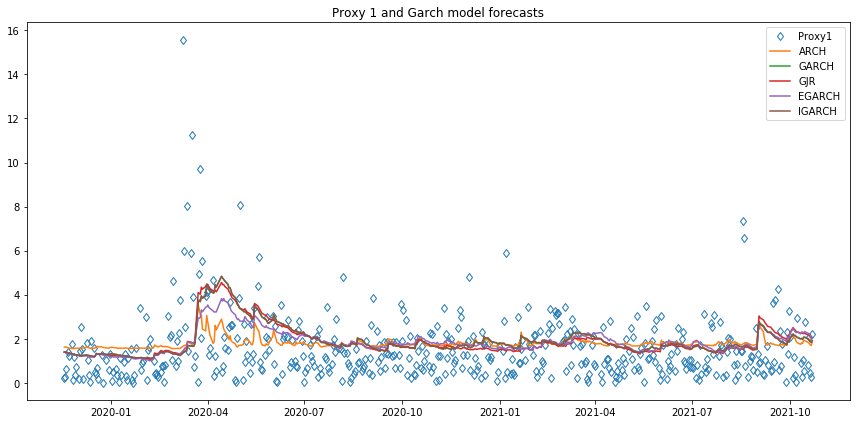

In [41]:
plt.figure(figsize=(12, 6))
plt.plot(np.sqrt(f_proxy1), 'd', mfc='none', label='Proxy1')
plt.plot(np.sqrt(farch5_10), label='ARCH')
plt.plot(np.sqrt(fgarch11_10), label='GARCH')
plt.plot(np.sqrt(fgjr11_10), label='GJR')
plt.plot(np.sqrt(fegarch_10), label='EGARCH')
plt.plot(np.sqrt(frm_10), label='IGARCH')
plt.title('Proxy 1 and Garch model forecasts')
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

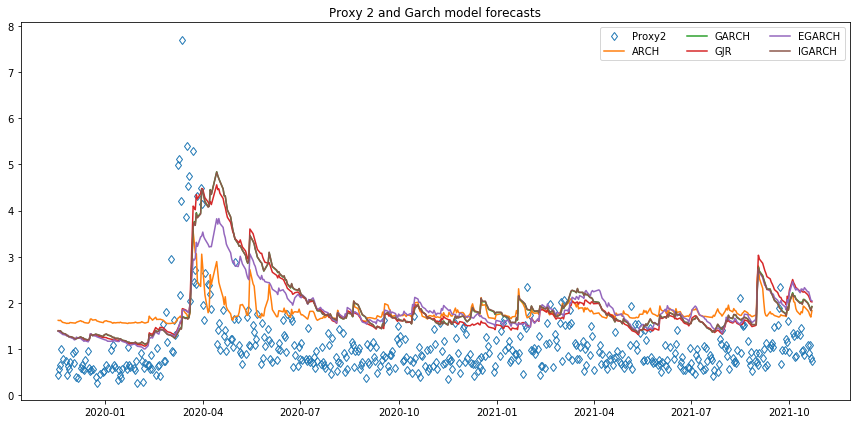

In [42]:
plt.figure(figsize=(12, 6))
plt.plot(np.sqrt(f_proxy2), 'd', mfc='none', label='Proxy2')
plt.plot(np.sqrt(farch5_10), label='ARCH')
plt.plot(np.sqrt(fgarch11_10), label='GARCH')
plt.plot(np.sqrt(fgjr11_10), label='GJR')
plt.plot(np.sqrt(fegarch_10), label='EGARCH')
plt.plot(np.sqrt(frm_10), label='IGARCH')
plt.title('Proxy 2 and Garch model forecasts')
plt.legend(fontsize=10, ncol=3)
plt.tight_layout()
plt.show()

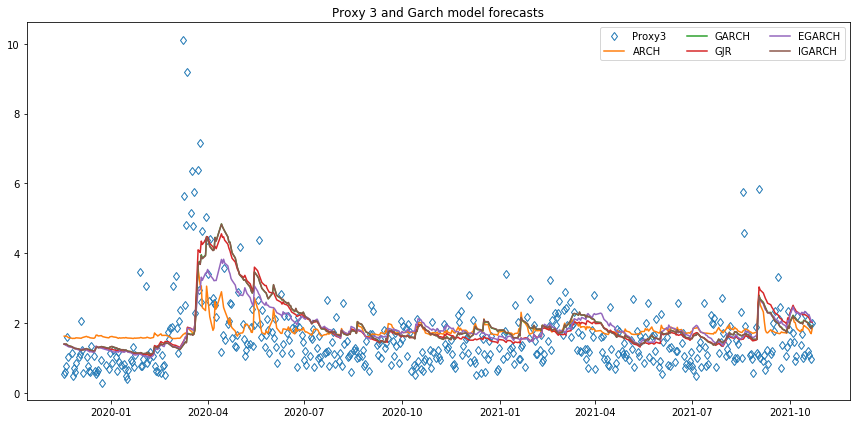

In [43]:
plt.figure(figsize=(12, 6))
plt.plot(np.sqrt(f_proxy3), 'd', mfc='none', label='Proxy3')
plt.plot(np.sqrt(farch5_10), label='ARCH')
plt.plot(np.sqrt(fgarch11_10), label='GARCH')
plt.plot(np.sqrt(fgjr11_10), label='GJR')
plt.plot(np.sqrt(fegarch_10), label='EGARCH')
plt.plot(np.sqrt(frm_10), label='IGARCH')
plt.title('Proxy 3 and Garch model forecasts')
plt.legend(fontsize=10, ncol=3)
plt.tight_layout()
plt.show()

### Answer guide
The parametric GARCH models all react fairly strongly to the start of Covid in early 2020, in their 10-day-ahead forecasts, except for the ARCH model. This model's lower estimated volatility persistence means that the initial effect of the higher volatility has died out 10 days later, with the volatility forecasts reverting to be closer to the long run variance estimated by the ARCH model, after 10 days. The ARCH model appears more accurate for proxies 1 and 3 during this period. 

The GARCH, GJR and RM model forecasts, on the other hand, take a much longer time to recover from the high volatility period. The EGARCH model sits between the ARCH and these 3 latter models in its 10 day forecast recivery after Covid hit. At most other times all the model are quite similar, sitting near to "the top" of the proxy data for each proxy. 

Below we see the usual behavior of the HS methods, taking 25 or 100 days to recover from high volatility periods, or barely reacting at all (HS-T). These methods seem comparatively innaccurate during this period. However, HS-T does seem quite accurate outside of high volatility periods. 

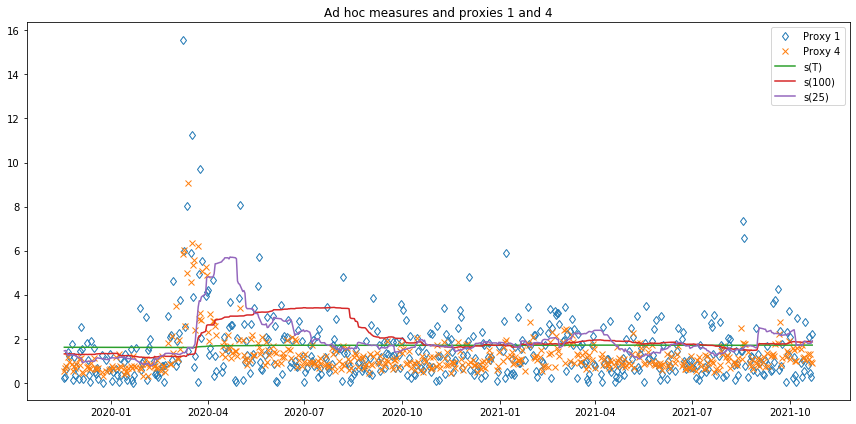

In [44]:
plt.figure(figsize=(12, 6))
plt.plot(np.sqrt(f_proxy1), 'd', mfc='none', label='Proxy 1')
plt.plot(np.sqrt(f_proxy4), 'x', mfc='none', label='Proxy 4')
plt.plot(np.sqrt(fs2_T_10), label='s(T)')
plt.plot(np.sqrt(fs2_100_10), label='s(100)')
plt.plot(np.sqrt(fs2_25_10), label='s(25)')
plt.title('Ad hoc measures and proxies 1 and 4')
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

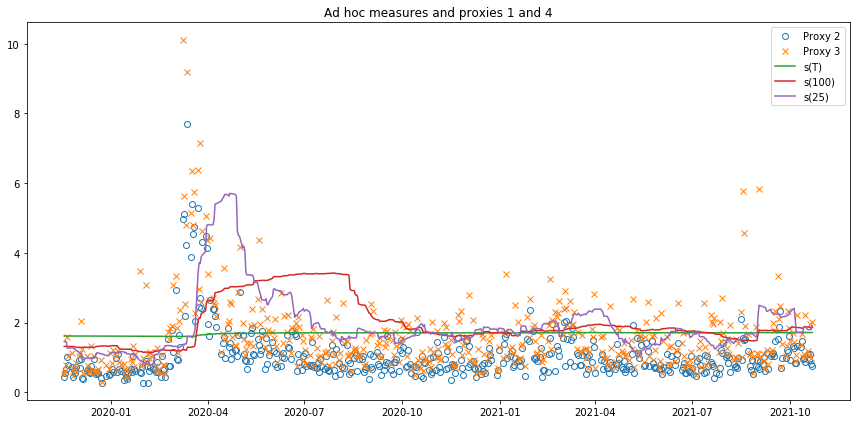

In [45]:
plt.figure(figsize=(12, 6))
plt.plot(np.sqrt(f_proxy2), 'o', mfc='none', label='Proxy 2')
plt.plot(np.sqrt(f_proxy3), 'x', mfc='none', label='Proxy 3')
plt.plot(np.sqrt(fs2_T_10), label='s(T)')
plt.plot(np.sqrt(fs2_100_10), label='s(100)')
plt.plot(np.sqrt(fs2_25_10), label='s(25)')
plt.title('Ad hoc measures and proxies 1 and 4')
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

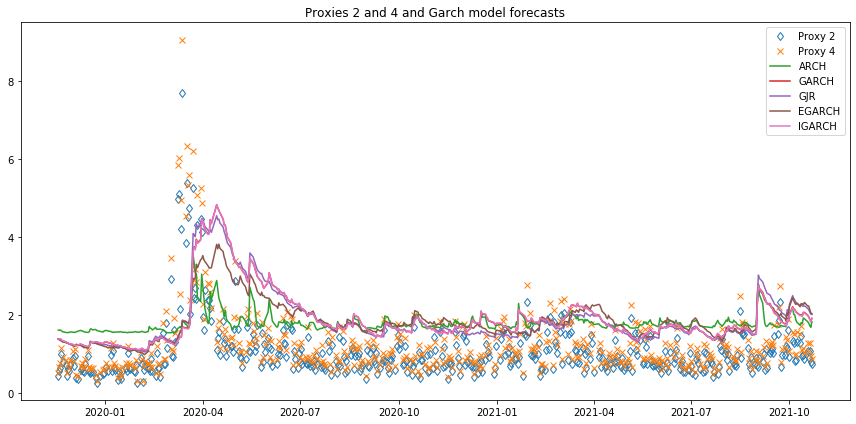

In [46]:
plt.figure(figsize=(12, 6))
plt.plot(np.sqrt(f_proxy2), 'd', mfc='none', label='Proxy 2')
plt.plot(np.sqrt(f_proxy4), 'x', label='Proxy 4')
plt.plot(np.sqrt(farch5_10), label='ARCH')
plt.plot(np.sqrt(fgarch11_10), label='GARCH')
plt.plot(np.sqrt(fgjr11_10), label='GJR')
plt.plot(np.sqrt(fegarch_10), label='EGARCH')
plt.plot(np.sqrt(frm_10), label='IGARCH')
plt.title('Proxies 2 and 4 and Garch model forecasts')
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

#### (f) Assess the accuracy of each model's forecasts using volatility proxies 1, 2 and 3. Which models did best overall? Did the proxies agree on which were the best models?

In [48]:
f_model = np.vstack([farch5_10, fgarch11_10, fgjr11_10, fegarch_10, frm_10, fs2_T_10, fs2_100_10, fs2_25_10]).T
f_proxy = np.vstack([f_proxy1, f_proxy2, f_proxy3, f_proxy4]).T

f_model = np.sqrt(f_model)
f_proxy = np.sqrt(f_proxy)

n_model = f_model.shape[1]
n_proxy = f_proxy.shape[1]

f_model_rep = f_model.repeat(n_proxy, axis=1)
f_proxy_rep = np.tile(f_proxy, [1, n_model])

rmse = np.sqrt(np.mean((f_model_rep - f_proxy_rep) ** 2, axis=0))
rmse = rmse.reshape(n_model, -1)

mad = np.mean(np.absolute(f_model_rep - f_proxy_rep), axis=0)
mad = mad.reshape(n_model, -1)

In [49]:
mdl_name = ['ARCH', 'GARCH', 'GJR', 'EGARCH', 'IGARCH', 's(T)', 's(100)', 's(25)']
prx_name = ['Proxy 1', 'Proxy 2', 'Proxy 3', 'Proxy 4']
tbl_rmse = pd.DataFrame(rmse, index=mdl_name, columns=prx_name)
tbl_rmse.round(4)

,Proxy 1,Proxy 2,Proxy 3,Proxy 4
ARCH,1.5064,1.0230,1.0430,1.0036
GARCH,1.5982,1.1964,1.1438,1.1447
GJR,1.5850,1.1668,1.1199,1.1150
EGARCH,1.5481,1.1005,1.0856,1.0631
IGARCH,1.5985,1.1974,1.1448,1.1460
s(T),1.5145,0.9826,1.0872,0.9961
s(100),1.6895,1.3491,1.3061,1.3129
s(25),1.6866,1.3193,1.2617,1.2657


In [50]:
tbl_mad = pd.DataFrame(mad, index=mdl_name, columns=prx_name)
tbl_mad.round(4)

,Proxy 1,Proxy 2,Proxy 3,Proxy 4
ARCH,1.0609,0.8989,0.7265,0.7977
GARCH,1.1138,0.9922,0.7970,0.8812
GJR,1.1015,0.9561,0.7753,0.8530
EGARCH,1.0829,0.9397,0.7519,0.8353
IGARCH,1.1143,0.9935,0.7979,0.8822
s(T),1.0358,0.8312,0.7175,0.7510
s(100),1.2058,1.1120,0.9236,1.0115
s(25),1.1533,1.0154,0.8388,0.9107


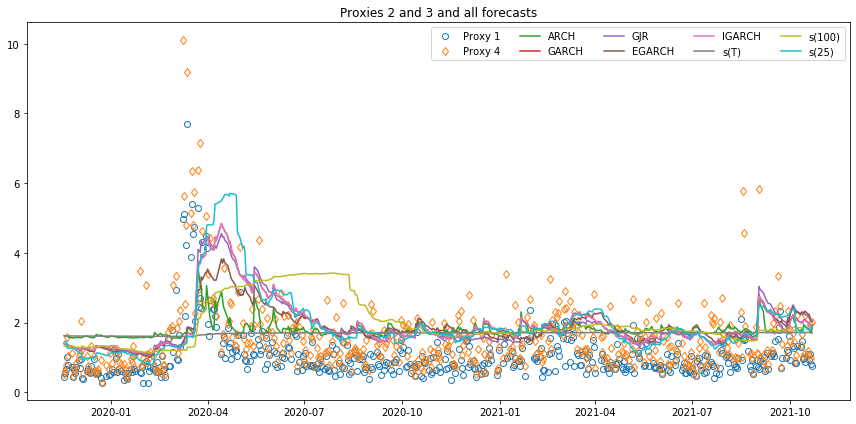

In [51]:
plt.figure(figsize=(12, 6))
plt.plot(np.sqrt(f_proxy2), 'o', mfc='none', label='Proxy 1')
plt.plot(np.sqrt(f_proxy3), 'd', mfc='none', label='Proxy 4')
plt.plot(np.sqrt(farch5_10), label='ARCH')
plt.plot(np.sqrt(fgarch11_10), label='GARCH')
plt.plot(np.sqrt(fgjr11_10), label='GJR')
plt.plot(np.sqrt(fegarch_10), label='EGARCH')
plt.plot(np.sqrt(frm_10), label='IGARCH')
plt.plot(np.sqrt(fs2_T_10), label='s(T)')
plt.plot(np.sqrt(fs2_100_10), label='s(100)')
plt.plot(np.sqrt(fs2_25_10), label='s(25)')
plt.title('Proxies 2 and 3 and all forecasts')
plt.legend(fontsize=10, ncol=5)
plt.tight_layout()
plt.show()

In [65]:
from scipy.stats import rankdata

rk_rmse1 = rankdata(rmse[:, 0])
rk_rmse2 = rankdata(rmse[:, 1])
rk_rmse3 = rankdata(rmse[:, 2])
rk_rmse4 = rankdata(rmse[:, 3])

models = ['ARCH', 'GARCH', 'GJR', 'EGARCH', 'IGARCH', 's(T)', 's(100)', 's(25)']
print(models)
average_rmse_rank = (rk_rmse4 + rk_rmse3 + rk_rmse2 + rk_rmse1)/4
average_rmse_rank

['ARCH', 'GARCH', 'GJR', 'EGARCH', 'IGARCH', 's(T)', 's(100)', 's(25)']


array([1.5 , 5.  , 4.  , 2.75, 6.  , 1.75, 8.  , 7.  ])

In [66]:
sorted(zip(average_rmse_rank, models))

[(1.5, 'ARCH'),
 (1.75, 's(T)'),
 (2.75, 'EGARCH'),
 (4.0, 'GJR'),
 (5.0, 'GARCH'),
 (6.0, 'IGARCH'),
 (7.0, 's(25)'),
 (8.0, 's(100)')]

In [67]:
rk_mad1 = rankdata(mad[:, 0])
rk_mad2 = rankdata(mad[:, 1])
rk_mad3 = rankdata(mad[:, 2])
rk_mad4 = rankdata(mad[:, 3])
print('ARCH', 'GARCH', 'GJR', 'EGARCH', 'IGARCH', 's(T)', 's(100)', 's(25)')

models = ['ARCH', 'GARCH', 'GJR', 'EGARCH', 'IGARCH', 's(T)', 's(100)', 's(25)']
print(models)
average_mad_rank = (rk_mad4+rk_mad3+rk_mad2+rk_mad1)/4
average_mad_rank

ARCH GARCH GJR EGARCH IGARCH s(T) s(100) s(25)
['ARCH', 'GARCH', 'GJR', 'EGARCH', 'IGARCH', 's(T)', 's(100)', 's(25)']


array([2., 5., 4., 3., 6., 1., 8., 7.])

In [68]:
sorted(zip(average_mad_rank, models))

[(1.0, 's(T)'),
 (2.0, 'ARCH'),
 (3.0, 'EGARCH'),
 (4.0, 'GJR'),
 (5.0, 'GARCH'),
 (6.0, 'IGARCH'),
 (7.0, 's(25)'),
 (8.0, 's(100)')]

In [24]:
rk_rmse1, rk_rmse2, rk_rmse3, rk_rmse4

(array([1., 5., 4., 3., 6., 2., 8., 7.]),
 array([2., 5., 4., 3., 6., 1., 8., 7.]),
 array([1., 5., 4., 2., 6., 3., 8., 7.]),
 array([2., 5., 4., 3., 6., 1., 8., 7.]))

In [25]:
rk_mad1, rk_mad2, rk_mad3, rk_mad4

(array([2., 5., 4., 3., 6., 1., 8., 7.]),
 array([2., 5., 4., 3., 6., 1., 8., 7.]),
 array([2., 5., 4., 3., 6., 1., 8., 7.]),
 array([2., 5., 4., 3., 6., 1., 8., 7.]))

#### Answer guide
Under RMSE, the HS-T and ARCH(5) models were most accurate. The ARCH model ranked 1st or 2nd for each proxy, whilst the HS-T method ranked in the top 3 for each proxy. By average rank, the ARCH(5) model was marginally better. 
Under MAD, remarkably the rank order of the models was exactly the same under all proxies: HS-T then ARCH ranked 1 and 2 each time. Thus, HS-T is preferred under MAD. 

HS-100 and HS-25 always ranked in the bottom 2 places (7 and 8) under both measures: they are the least accurate 10-day volatility forecasters in this period for BHP.

The EGARCH model almost always ranked 3rd under both measures, while GJR and GARCH always ranked 4th and 5th respectively and RM always ranked 6th. 

The ARCH and HS-T models both had the smallest reactions to the Covid hitting and the subsequent high volatility period, in their 10-day volatility forecasts. The ARCH did this by estimating a smaller persistence than other GARCH models, whilst the HS-T did it by using the sample variance of all the sample size T, being not strongly affected by a small number of more extreme returns as T is high.  